In [292]:
# Playing with the classic dataset, originally inspired by Andrey Lukyanenko's work at https://github.com/Erlemar/Erlemar.github.io/blob/master/Notebooks/Titanic.ipynb
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

In [293]:
base_path = 'E:\\Projects\\titanic\\data'
# Train / test data - start with data exploration, then circle back with train/test split
df_train = pd.read_csv(os.path.join(base_path, 'train.csv'))
# Kaggle test data
df_test = pd.read_csv(os.path.join(base_path, 'test.csv'))

In [294]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [295]:
df_train['Pclass'].unique()

array([3, 1, 2], dtype=int64)

In [296]:
# Does the number of family members a passenger have affect survivability? 
# e.g., would assistance from parents, spouse, etc. help improve your chances?

def family(df):
    df['Family'] = df['SibSp'] + df['Parch']
    return None

def family2(sz):
    # Courtesy https://www.cdc.gov/mmwr/preview/mmwrhtml/mm4847a1.htm , average family size around this time is 
    # 3.5 children --> 5.5 
    if sz == 1:
        return 'single'
    if sz < 5:
        return 'small'
    if sz > 6:
        return 'large'
    return 'medium'

In [297]:
family(df_train)
family(df_test)
df_train['Family'] = df_train['Family'].apply(lambda x: family2(x))
df_test['Family'] = df_test['Family'].apply(lambda x: family2(x))

In [298]:
df_train['Family'].value_counts()
df_train.groupby(['Pclass', 'Family'])['Survived'].mean()

Pclass  Family
1       medium    0.500000
        single    0.728571
        small     0.584507
2       medium    1.000000
        single    0.529412
        small     0.456376
3       large     0.000000
        medium    0.137931
        single    0.350877
        small     0.242347
Name: Survived, dtype: float64

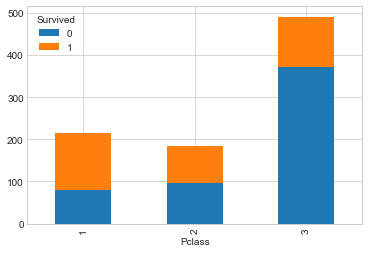

In [299]:
plt.figure()
df_train.pivot_table('PassengerId', 'Pclass', 'Survived', 'count').plot(kind='bar', stacked=True)

In [300]:
df_train['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [301]:
import re
df_train['Title'] = df_train['Name'].apply(lambda x: (re.search(' ([a-zA-Z]+)\.', x)).group(1))
df_test['Title'] = df_test['Name'].apply(lambda x: (re.search(' ([a-zA-Z]+)\.', x)).group(1))
df_train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [302]:
# Have a look at rough social classes
soclasses = {
    'upper': ('Sir', 'Lady', 'Don', 'Countess', 'Jonkheer'), 
    'pro': ('Dr', 'Rev', 'Major', 'Col', 'Capt'), 
    'middle': ('Mr', 'Miss', 'Mrs', 'Master', 'Mlle', 'Ms', 'Mme')
}
for soclass in soclasses:
    df_train.loc[df_train['Title'].isin(soclasses[soclass]), 'SocialClass'] = soclass
    df_test.loc[df_test['Title'].isin(soclasses[soclass]), 'SocialClass'] = soclass
    
df_train['SocialClass'].fillna('U', inplace=True)
df_test['SocialClass'].fillna('U', inplace=True)

In [303]:
# Fill in any missing ages with the median for the passenger class, sex, and social class
def impute_age(df):
    df['Age'] = df.groupby(['Sex', 'Pclass', 'SocialClass'])['Age'].apply(lambda x: x.fillna(x.median()))

impute_age(df_train)
impute_age(df_test)

In [304]:
# Fill in any missing ticket fares with the median for passenger class, sex, and age
def impute_fare(df):
    df['Fare'] = df.groupby(['Sex', 'Pclass', 'Age'])['Fare'].apply(lambda x: x.fillna(x.median()))

impute_fare(df_train)
impute_fare(df_test)

In [305]:
# Fill in missing Embarked info with 'U' (unknown)
df_train['Embarked'].fillna('U', inplace=True)
df_test['Embarked'].fillna('U', inplace=True)

# Ditto Title...
df_train['Title'].fillna('U', inplace=True)
df_test['Title'].fillna('U', inplace=True)

# ... and cabin info 
df_train['Cabin'].fillna('U0', inplace=True)
df_test['Cabin'].fillna('U0', inplace=True)
# Add a deck feature
df_train['CabinDeck'] = df_train['Cabin'].map(lambda x: x[0])
df_test['CabinDeck'] = df_test['Cabin'].map(lambda x: x[0])

# Deck layouts look like cabin numbers might be interesting (low numbers are aft)
def cabin_num(x):
    toks = x.split()
    try:
        val = int(toks[0][1:])
    except Exception as err:
        val = 0
    finally:
        return val
    
# Try grouping in groups of 10
def grpcabin(x):
    grp = 0
    for i in range(0, 1000, 10):
        if x > i:
            grp += 1
        else:
            return grp
        
df_train['CabinNo'] = df_train['Cabin'].map(lambda x: cabin_num(x)).apply(grpcabin)
df_test['CabinNo'] = df_test['Cabin'].map(lambda x: cabin_num(x)).apply(grpcabin)
df_train.groupby(['CabinNo']).mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
CabinNo,,,,,,,
0,442.503597,0.300719,2.635971,27.145683,0.542446,0.362590,19.110155
1,377.222222,0.703704,1.555556,27.314815,0.481481,0.592593,62.023144
2,560.611111,0.833333,1.000000,42.777778,0.444444,0.111111,50.349089
3,466.400000,0.560000,1.000000,37.796800,0.640000,0.920000,96.852500
4,396.357143,0.750000,1.178571,36.303571,0.321429,0.321429,59.593307
5,563.428571,0.666667,1.000000,39.571429,0.380952,0.333333,65.937895
6,410.000000,0.727273,1.090909,32.136364,0.363636,0.636364,156.446964
7,549.000000,0.636364,1.000000,33.272727,0.727273,0.818182,104.447718
8,437.600000,0.700000,1.100000,36.700000,0.500000,0.000000,88.854160


In [306]:
df_train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,CabinNo
PassengerId,1.000000,-0.005007,-0.035144,0.040091,-0.057527,-0.001652,0.012658,0.029668
Survived,-0.005007,1.000000,-0.338481,-0.059662,-0.035322,0.081629,0.257307,0.243628
Pclass,-0.035144,-0.338481,1.000000,-0.411396,0.083081,0.018443,-0.549500,-0.603300
Age,0.040091,-0.059662,-0.411396,1.000000,-0.249289,-0.174904,0.122079,0.240026
SibSp,-0.057527,-0.035322,0.083081,-0.249289,1.000000,0.414838,0.159651,-0.035054
Parch,-0.001652,0.081629,0.018443,-0.174904,0.414838,1.000000,0.216225,0.007560
Fare,0.012658,0.257307,-0.549500,0.122079,0.159651,0.216225,1.000000,0.427849
CabinNo,0.029668,0.243628,-0.603300,0.240026,-0.035054,0.007560,0.427849,1.000000


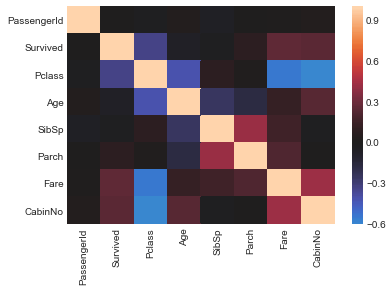

In [307]:
#print(df_train.columns)
# So far the most interesting attributes for Survival are Fare, CabinNo, and Pclass
features = ["Fare", "CabinNo", "Pclass"]
plt.figure()
sns.heatmap(df_train.corr(), center=0)

In [308]:
# Closer look at the columns
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Family          object
Title           object
SocialClass     object
CabinDeck       object
CabinNo          int64
dtype: object

In [309]:
# Ticket prefix might be interesting, ticket number maybe not so much
tmp = df_train['Ticket'].str.split()
df_train['TicketPrefix'] = tmp.apply(lambda x: x[0] + x[1] if len(x) == 3 else (x[0] if len(x) == 2 else 'U'))
tmp = df_test['Ticket'].str.split()
df_test['TicketPrefix'] = tmp.apply(lambda x: x[0] + x[1] if len(x) == 3 else (x[0] if len(x) == 2 else 'U'))

In [310]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

def onehot_column(df, col):
    enc = LabelBinarizer()
    arr = enc.fit_transform(df[col])
    df[col] = arr
    

def encode_column(df, col):
    enc = LabelEncoder()
    arr = enc.fit_transform(df[col])
    df[col] = arr

In [311]:
# One hot encode categorical columns w/o ordinality
for col in ['Sex', 'TicketPrefix', 'Embarked', 'Title']:
    onehot_column(df_train, col)
    onehot_column(df_test, col)
    
# Label encode categorical columns with ordinality
for col in ['CabinDeck', 'CabinNo', 'Family', 'SocialClass']:
    encode_column(df_train, col)
    encode_column(df_test, col)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Title,SocialClass,CabinDeck,CabinNo,TicketPrefix
PassengerId,1.000000,-0.005007,-0.035144,0.042939,0.040091,-0.057527,-0.001652,0.012658,-0.001205,0.069280,0.039097,0.061248,-0.030939,0.029036,-0.024342
Survived,-0.005007,1.000000,-0.338481,-0.543351,-0.059662,-0.035322,0.081629,0.257307,0.168240,-0.000495,-0.026456,0.002855,-0.301116,0.243581,-0.037436
Pclass,-0.035144,-0.338481,1.000000,0.131900,-0.411396,0.083081,0.018443,-0.549500,-0.243292,0.014747,-0.052496,-0.188478,0.746616,-0.603809,0.039243
Sex,0.042939,-0.543351,0.131900,1.000000,0.101603,-0.114631,-0.245489,-0.182333,-0.082853,0.151912,0.024728,0.056026,0.123076,-0.099187,0.034990
Age,0.040091,-0.059662,-0.411396,0.101603,1.000000,-0.249289,-0.174904,0.122079,0.042676,0.123110,0.103208,0.184765,-0.292854,0.240570,-0.021745
SibSp,-0.057527,-0.035322,0.083081,-0.114631,-0.249289,1.000000,0.414838,0.159651,-0.059528,-0.717240,0.014507,-0.023171,0.041540,-0.034931,-0.022508
Parch,-0.001652,0.081629,0.018443,-0.245489,-0.174904,0.414838,1.000000,0.216225,-0.011069,-0.427566,0.025731,-0.059277,-0.032548,0.007763,-0.022467
Fare,0.012658,0.257307,-0.549500,-0.182333,0.122079,0.159651,0.216225,1.000000,0.269335,-0.208933,0.026184,0.018150,-0.523013,0.428670,-0.023068
Embarked,-0.001205,0.168240,-0.243292,-0.082853,0.042676,-0.059528,-0.011069,0.269335,1.000000,-0.002195,-0.016158,0.052302,-0.243017,0.159167,-0.022864
Family,0.069280,-0.000495,0.014747,0.151912,0.123110,-0.717240,-0.427566,-0.208933,-0.002195,1.000000,0.016483,0.021772,0.058118,-0.044399,0.023323


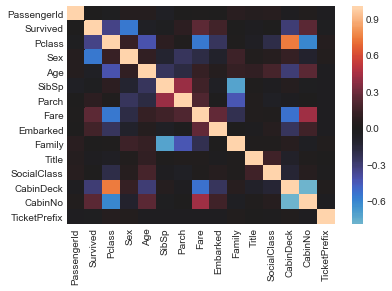

In [312]:
# The originally interesting features were Fare, CabinNo, and Pclass - where are we now?
plt.figure()
sns.heatmap(df_train.corr(), center=0)
df_train.corr()

In [313]:
# Looks like Sex, Embarked, and CabinDeck can be added; maybe Age, SibSp, Parch, Title, and TicketPrefix
features = ['Fare', 'CabinNo', 'Pclass', 'Sex', 'Embarked', 'CabinDeck', 'Age', 'SibSp', 'Parch', 'Title', 'TicketPrefix']

In [314]:
df_train[features].describe()

,Fare,CabinNo,Pclass,Sex,Embarked,CabinDeck,Age,SibSp,Parch,Title,TicketPrefix
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,32.204208,1.200898,2.308642,0.647587,0.188552,6.716049,29.091100,0.523008,0.381594,0.001122,0.002245
std,49.693429,2.818287,0.836071,0.477990,0.391372,2.460739,13.293942,1.102743,0.806057,0.033501,0.047351
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,7.910400,0.000000,2.000000,0.000000,0.000000,8.000000,21.500000,0.000000,0.000000,0.000000,0.000000
50%,14.454200,0.000000,3.000000,1.000000,0.000000,8.000000,26.000000,0.000000,0.000000,0.000000,0.000000
75%,31.000000,0.000000,3.000000,1.000000,0.000000,8.000000,36.000000,1.000000,0.000000,0.000000,0.000000
max,512.329200,14.000000,3.000000,1.000000,1.000000,8.000000,80.000000,8.000000,6.000000,1.000000,1.000000


In [315]:
# Let's scale Fare 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

def scale_col(df, col):
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    df[col] = imp.fit_transform(df[[col]])
    scaler = StandardScaler()
    df[col] = scaler.fit_transform(df[[col]])

scale_col(df_train, 'Fare')
scale_col(df_test, 'Fare')
df_train[features].describe()
# How are we doing for class balance?
df_train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [316]:
# Not bad but let's try balancing
classes = df_train['Survived'].unique().tolist()
weights = {
    k: 1 - len(df_train[df_train['Survived'] == k]) / len(df_train['Survived']) for k in classes
}
weights

{0: 0.38383838383838387, 1: 0.6161616161616161}

In [317]:
# Try adding Euclidean distances from centroids 
from sklearn.cluster import KMeans
train = df_train[features].copy()
kmeans = KMeans().fit(train)

def add_kmeans_features(df):
    train_dists = kmeans.transform(df[features])
    for col in range(train_dists.shape[1]):
        colname = 'dist{0}'.format(col)
        df.loc[:, colname] = train_dists[:,col]
        scale_col(df, colname)
        
add_kmeans_features(df_train)
add_kmeans_features(df_test)
features.extend([col for col in train if col.startswith('dist')])

In [318]:
print(df_train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    1  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    0  38.0      1      0   
2                             Heikkinen, Miss. Laina    0  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    0  35.0      1      0   
4                           Allen, Mr. William Henry    1  35.0      0      0   

             Ticket      Fare    ...    CabinNo  TicketPrefix     dist0  \
0         A/5 21171 -0.502445    ...          0             0 -0.598335   
1          PC 17599  0.786845    ...          9             0  0.766014   
2  STON/O2. 3101282 -0.488854    ...          0             0 -0.282673

In [319]:
from sklearn.externals import joblib
import sklearn
import multiprocessing as mp
import sys
import time
import platform
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


def persist_model(mdl, basename, **kwargs):
    version = sys.version_info
    metadata = {
        'versions': {
            'python': '{0}.{1}.{2}'.format(version.major, version.minor, version.micro),
            'pandas': pd.__version__,
            'sklearn': sklearn.__version__
        }
    }
    if kwargs is not None:
        metadata.update(**kwargs)
    outname = '{0}_{1}.pkl'.format(basename, int(time.time()))
    bndl = {
        'model': mdl,
        'metadata': metadata
    }
    joblib.dump(clf, outname)
    return outname


def grid_search(clz, X, y, parameters=None):
    clf = GridSearchCV(estimator=clz, param_grid=parameters, verbose=1, n_jobs=mp.cpu_count() - 1, cv=5)
    clf.fit(X, y)
    return clf


# We'll look at an SVC first, then use it as a benchmark of sorts for the Random Forest model.

def find_svc(X, y):
    parameters = {'kernel':('linear', 'rbf', 'sigmoid'), 'C': [1, 10, 0.5, 0.75, 0.25]}
    return grid_search(SVC(), X, y, parameters)

train = df_train.copy()
clf = find_svc(train[features], train['Survived'])
print('Metrics: Best score = {0} using params = {1}\n'.format(clf.best_score_, clf.best_params_))


def find_rf(X, y):
    parameters = {
        'n_estimators': [10, 20, 50, 64, 100, 128, 256], 
        'criterion': ['gini', 'entropy'],
        'max_features': ['sqrt', 'log2', None, 0.1, 0.25, 0.5, 0.75],
        'min_samples_split': [0.1, 0.25, 0.5, 0.75, 1.0],
        'verbose': [True],
        'oob_score': [True],
        'class_weight': [weights, "balanced_subsample", None],
        'n_jobs': [-1]
    }
    return grid_search(RandomForestClassifier(), X, y, parameters)

train = df_train.copy()
clf2 = find_rf(train[features], train['Survived'])
print('Metrics: Best score = {0} using params = {1}'.format(clf2.best_score_, clf2.best_params_))

   
saved_model = persist_model(clf2, 'titanic_rf', features=features)
print("Model and metadata saved to '{0}'".format(saved_model))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   16.5s
[Parallel(n_jobs=7)]: Done  75 out of  75 | elapsed:  1.0min finished


Metrics: Best score = 0.8013468013468014 using params = {'C': 10, 'kernel': 'rbf'}

Fitting 5 folds for each of 1470 candidates, totalling 7350 fits


[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    8.3s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:   20.9s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:   42.6s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:  1.9min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed:  2.7min
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed:  3.6min
[Parallel(n_jobs=7)]: Done 3186 tasks      | elapsed:  4.9min
[Parallel(n_jobs=7)]: Done 4036 tasks      | elapsed:  6.4min
[Parallel(n_jobs=7)]: Done 4986 tasks      | elapsed:  8.0min
[Parallel(n_jobs=7)]: Done 6036 tasks      | elapsed:  9.5min
[Parallel(n_jobs=7)]: Done 7186 tasks      | elapsed: 11.2min
[Parallel(n_jobs=7)]: Done 7350 out of 7350 | elapsed: 11.4min finished


Metrics: Best score = 0.8103254769921436 using params = {'min_samples_split': 0.1, 'class_weight': None, 'n_jobs': -1, 'verbose': True, 'criterion': 'entropy', 'max_features': None, 'oob_score': True, 'n_estimators': 50}
Model and metadata saved to 'titanic_rf_1522592121.pkl'


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished


In [320]:
# Ok let's do this
submission_df = pd.DataFrame(
    {
        'PassengerId': df_test['PassengerId'],
        'Survived': clf2.predict(df_test[features])
    }
)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


In [321]:
submission = submission_df.to_csv(
    'titanic.csv',
    index=False
)